# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import os, time
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Housekeeping Functions

In [3]:
def save_checkpoint(model, optimizer, filename='checkpoint.pyt'):
    checkpoint = {'model_state_dict': model.state_dict(),
                  'model_output_class': model.classifier.out_features,
                  'optimizer_state_dict': optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx}

    torch.save(checkpoint, filename)

In [4]:
def load_checkpoint(filepath='checkpoint.pyt'):

    checkpoint = torch.load(filepath)
    
    model_output_class = checkpoint['model_output_class']
    model = models.densenet121(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.features.denseblock4.parameters():
        param.requires_grad = True
    n_inputs = model.classifier.in_features
    last_layer = nn.Linear(n_inputs, model_output_class)
    model.classifier = last_layer
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    model.eval()
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.00001, momentum=0.009)
    #bar optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer

In [5]:
def generate_idx_to_class(class_to_idx):
    idx_to_class = {}
    for key, value in class_to_idx.items():
        idx_to_class[value] = key
    return idx_to_class

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [6]:
data_dir = '../flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

Normalizer mean and standard deviation is based on [TorchVision Models Document](https://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
# TODO: Define your transforms for the training and validation sets
train_data_transforms = transforms.Compose([transforms.RandomResizedCrop(224), 
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.485, 0.456, 0.406), 
                                                                 (0.229, 0.224, 0.225))])

valid_data_transforms = transforms.Compose([transforms.Resize((224, 224)), 
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.485, 0.456, 0.406), 
                                                                 (0.229, 0.224, 0.225))])

# TODO: Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform=train_data_transforms)
valid_datasets = datasets.ImageFolder(valid_dir, transform=valid_data_transforms)

# print out some data stats
print('Num training images: ', len(train_datasets))
print('Num validation images: ', len(valid_datasets))

Num training images:  6552
Num validation images:  818


In [8]:
# TODO: Using the image datasets and the trainforms, define the dataloaders
batch_size = 20
num_workers = 12

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_datasets, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

In [9]:
train_loader

In [10]:
valid_loader

In [11]:
class_to_idx = train_datasets.class_to_idx

In [12]:
class_to_idx

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '11': 5,
 '12': 6,
 '13': 7,
 '14': 8,
 '15': 9,
 '16': 10,
 '17': 11,
 '18': 12,
 '19': 13,
 '2': 14,
 '20': 15,
 '21': 16,
 '22': 17,
 '23': 18,
 '24': 19,
 '25': 20,
 '26': 21,
 '27': 22,
 '28': 23,
 '29': 24,
 '3': 25,
 '30': 26,
 '31': 27,
 '32': 28,
 '33': 29,
 '34': 30,
 '35': 31,
 '36': 32,
 '37': 33,
 '38': 34,
 '39': 35,
 '4': 36,
 '40': 37,
 '41': 38,
 '42': 39,
 '43': 40,
 '44': 41,
 '45': 42,
 '46': 43,
 '47': 44,
 '48': 45,
 '49': 46,
 '5': 47,
 '50': 48,
 '51': 49,
 '52': 50,
 '53': 51,
 '54': 52,
 '55': 53,
 '56': 54,
 '57': 55,
 '58': 56,
 '59': 57,
 '6': 58,
 '60': 59,
 '61': 60,
 '62': 61,
 '63': 62,
 '64': 63,
 '65': 64,
 '66': 65,
 '67': 66,
 '68': 67,
 '69': 68,
 '7': 69,
 '70': 70,
 '71': 71,
 '72': 72,
 '73': 73,
 '74': 74,
 '75': 75,
 '76': 76,
 '77': 77,
 '78': 78,
 '79': 79,
 '8': 80,
 '80': 81,
 '81': 82,
 '82': 83,
 '83': 84,
 '84': 85,
 '85': 86,
 '86': 87,
 '87': 88,
 '88': 89,
 '89': 90,
 '9': 91,
 '90

In [13]:
idx_to_class = generate_idx_to_class(class_to_idx)

In [14]:
idx_to_class

{0: '1',
 1: '10',
 2: '100',
 3: '101',
 4: '102',
 5: '11',
 6: '12',
 7: '13',
 8: '14',
 9: '15',
 10: '16',
 11: '17',
 12: '18',
 13: '19',
 14: '2',
 15: '20',
 16: '21',
 17: '22',
 18: '23',
 19: '24',
 20: '25',
 21: '26',
 22: '27',
 23: '28',
 24: '29',
 25: '3',
 26: '30',
 27: '31',
 28: '32',
 29: '33',
 30: '34',
 31: '35',
 32: '36',
 33: '37',
 34: '38',
 35: '39',
 36: '4',
 37: '40',
 38: '41',
 39: '42',
 40: '43',
 41: '44',
 42: '45',
 43: '46',
 44: '47',
 45: '48',
 46: '49',
 47: '5',
 48: '50',
 49: '51',
 50: '52',
 51: '53',
 52: '54',
 53: '55',
 54: '56',
 55: '57',
 56: '58',
 57: '59',
 58: '6',
 59: '60',
 60: '61',
 61: '62',
 62: '63',
 63: '64',
 64: '65',
 65: '66',
 66: '67',
 67: '68',
 68: '69',
 69: '7',
 70: '70',
 71: '71',
 72: '72',
 73: '73',
 74: '74',
 75: '75',
 76: '76',
 77: '77',
 78: '78',
 79: '79',
 80: '8',
 81: '80',
 82: '81',
 83: '82',
 84: '83',
 85: '84',
 86: '85',
 87: '86',
 88: '87',
 89: '88',
 90: '89',
 91: '9',
 92:

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [15]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [16]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [17]:
# TODO: Build and train your network
# Load the pretrained model from pytorch
d121 = models.densenet121(pretrained=True)

# print out the model structure
print(d121)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

/home/eka/anaconda3/envs/pytorch0.4/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [18]:
# Freeze training for all "features" layers
for param in d121.features.parameters():
    param.requires_grad = False

In [19]:
print(d121.classifier.in_features) 
print(d121.classifier.out_features) 

1024
1000


In [20]:
len(cat_to_name)

102

Pretrained VGG16 has 1000 classes as the output. Replace the classification layer to output only 102 classes.

In [21]:
n_inputs = d121.classifier.in_features
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(cat_to_name))

d121.classifier = last_layer

print(d121)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [22]:
print(d121.classifier.in_features)
print(d121.classifier.out_features)

1024
102


In [23]:
d121.class_to_idx = class_to_idx

In [24]:
# if GPU is available, move the model to GPU
if train_on_gpu:
    d121.cuda()

In [25]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(d121.classifier.parameters(), lr=0.001, momentum=0.9)

In [18]:
best_test_accuracy = 0.0

# number of epochs to train the model
n_epochs = 100

for epoch in range(1, n_epochs+1):

    ###################
    # train the model #
    ###################
    tic = time.time()
    # keep track of training and validation loss
    train_loss = 0.0
    total_accumulated_train_loss = 0
    
    # model by default is set to train
    d121.train() # eval mode
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = d121(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        total_accumulated_train_loss += 1
        
        if batch_i % 100 == 99:    # print training loss every specified number of mini-batches
            print('Epoch %2d, Batch %4d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / total_accumulated_train_loss))
            train_loss = 0.0
            total_accumulated_train_loss = 0
    
    last_train_loss = train_loss / total_accumulated_train_loss
    
    toc = time.time()
    train_time = toc - tic
    
    ######################    
    # validate the model #
    ######################
    tic = time.time()
    # track test loss 
    # over 5 flower classes
    test_loss = 0.0
    class_correct = list(0. for i in range(len(cat_to_name)))
    class_total = list(0. for i in range(len(cat_to_name)))

    # iterate over test data
    d121.eval() # eval mode
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = d121(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss 
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate avg test loss
    test_loss = test_loss / len(valid_loader.dataset)
    
    toc = time.time()
    test_time = toc - tic
    
    print("Train Time    : %9d seconds" % int(train_time))
    print('Train Loss    : {:9.6f}'.format(last_train_loss))
    print("Test Time     : %9d seconds" % int(test_time))
    print('Test Loss     : {:9.6f}'.format(test_loss))
    test_accuracy = (100. * np.sum(class_correct)) / np.sum(class_total)
    print('Test Accuracy : %2d%% (%2d/%2d)' % (test_accuracy, 
                                               np.sum(class_correct), 
                                               np.sum(class_total)))
    
    if test_accuracy > best_test_accuracy:
        print('Saving Checkpoint...')
        save_checkpoint(d121, optimizer, filename='checkpoint.pyt')
        best_test_accuracy = test_accuracy
        

Epoch  1, Batch  100 loss: 0.2395645605400205
Epoch  1, Batch  200 loss: 0.2528727291338146
Epoch  1, Batch  300 loss: 0.2242244930751622
Train Time    :        34 seconds
Train Loss    :  0.243898
Test Time     :         4 seconds
Test Loss     :  0.230306
Test Accuracy : 94% (776/818)
Saving Checkpoint...
Epoch  2, Batch  100 loss: 0.2410397115722299
Epoch  2, Batch  200 loss: 0.2561158974841237
Epoch  2, Batch  300 loss: 0.2220353990606964
Train Time    :        34 seconds
Train Loss    :  0.276695
Test Time     :         4 seconds
Test Loss     :  0.226412
Test Accuracy : 94% (774/818)
Epoch  3, Batch  100 loss: 0.2559044988825917
Epoch  3, Batch  200 loss: 0.2437008745595813
Epoch  3, Batch  300 loss: 0.2199545829929411
Train Time    :        34 seconds
Train Loss    :  0.267397
Test Time     :         4 seconds
Test Loss     :  0.231806
Test Accuracy : 94% (774/818)
Epoch  4, Batch  100 loss: 0.2584109558537602
Epoch  4, Batch  200 loss: 0.2449003751948476
Epoch  4, Batch  300 lo

Epoch 29, Batch  300 loss: 0.2276822891458869
Train Time    :        34 seconds
Train Loss    :  0.277894
Test Time     :         4 seconds
Test Loss     :  0.227824
Test Accuracy : 94% (777/818)
Epoch 30, Batch  100 loss: 0.2385708179697394
Epoch 30, Batch  200 loss: 0.2532350591197610
Epoch 30, Batch  300 loss: 0.2231255334243178
Train Time    :        34 seconds
Train Loss    :  0.275749
Test Time     :         4 seconds
Test Loss     :  0.228349
Test Accuracy : 95% (779/818)
Epoch 31, Batch  100 loss: 0.2610908472165465
Epoch 31, Batch  200 loss: 0.2440151976421475
Epoch 31, Batch  300 loss: 0.2723148595355451
Train Time    :        34 seconds
Train Loss    :  0.282850
Test Time     :         4 seconds
Test Loss     :  0.237626
Test Accuracy : 94% (771/818)
Epoch 32, Batch  100 loss: 0.2394444083049893
Epoch 32, Batch  200 loss: 0.2384945196658373
Epoch 32, Batch  300 loss: 0.2365811254642904
Train Time    :        34 seconds
Train Loss    :  0.259650
Test Time     :         4 seco

Epoch 58, Batch  100 loss: 0.2563756764307618
Epoch 58, Batch  200 loss: 0.2038658083975315
Epoch 58, Batch  300 loss: 0.2184430044516921
Train Time    :        34 seconds
Train Loss    :  0.255236
Test Time     :         4 seconds
Test Loss     :  0.232627
Test Accuracy : 94% (777/818)
Epoch 59, Batch  100 loss: 0.2482058818638325
Epoch 59, Batch  200 loss: 0.2211596075631678
Epoch 59, Batch  300 loss: 0.2441404441744089
Train Time    :        34 seconds
Train Loss    :  0.252093
Test Time     :         4 seconds
Test Loss     :  0.237331
Test Accuracy : 94% (774/818)
Epoch 60, Batch  100 loss: 0.2562689628452063
Epoch 60, Batch  200 loss: 0.2417413646541536
Epoch 60, Batch  300 loss: 0.2325101150758564
Train Time    :        34 seconds
Train Loss    :  0.229271
Test Time     :         4 seconds
Test Loss     :  0.239578
Test Accuracy : 94% (776/818)
Epoch 61, Batch  100 loss: 0.2585890035703778
Epoch 61, Batch  200 loss: 0.2376408346742392
Epoch 61, Batch  300 loss: 0.270850495807826

Train Time    :        34 seconds
Train Loss    :  0.274046
Test Time     :         4 seconds
Test Loss     :  0.236640
Test Accuracy : 94% (769/818)
Epoch 87, Batch  100 loss: 0.2204680381342769
Epoch 87, Batch  200 loss: 0.2459789148624986
Epoch 87, Batch  300 loss: 0.2704441995918751
Train Time    :        34 seconds
Train Loss    :  0.274937
Test Time     :         4 seconds
Test Loss     :  0.226677
Test Accuracy : 94% (776/818)
Epoch 88, Batch  100 loss: 0.2401975206285715
Epoch 88, Batch  200 loss: 0.2315824348106980
Epoch 88, Batch  300 loss: 0.2657846384495497
Train Time    :        34 seconds
Train Loss    :  0.220922
Test Time     :         4 seconds
Test Loss     :  0.240374
Test Accuracy : 94% (771/818)
Epoch 89, Batch  100 loss: 0.2586771244555712
Epoch 89, Batch  200 loss: 0.2475749726593494
Epoch 89, Batch  300 loss: 0.2576764354109764
Train Time    :        34 seconds
Train Loss    :  0.277220
Test Time     :         4 seconds
Test Loss     :  0.237103
Test Accuracy : 

```
 - GPU                     : Nvidia GTX 1060
 - GPU utilization trainig : 98%
 - GPU utilization testing : 98%
 - GPU memory consmptoin   : 999 MiB
 - Train time / epoch      : 35 seconds
 - Test time / epoch       : 4 seconds
 - Best Test Accuracy      : 95% (779/818)

```

Test

In [26]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(len(cat_to_name)))
class_total = list(0. for i in range(len(cat_to_name)))

# iterate over test data
d121.eval() # eval mode
for data, target in valid_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = d121(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(cat_to_name)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            cat_to_name[str(i+1)], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.222647

Test Accuracy of pink primrose: 100% ( 8/ 8)
Test Accuracy of hard-leaved pocket orchid: 100% ( 4/ 4)
Test Accuracy of canterbury bells: 100% ( 6/ 6)
Test Accuracy of sweet pea: 100% ( 5/ 5)
Test Accuracy of english marigold: 100% ( 6/ 6)
Test Accuracy of tiger lily: 70% ( 7/10)
Test Accuracy of moon orchid: 80% ( 4/ 5)
Test Accuracy of bird of paradise: 80% ( 4/ 5)
Test Accuracy of monkshood: 100% ( 1/ 1)
Test Accuracy of globe thistle: 100% ( 7/ 7)
Test Accuracy of snapdragon: 100% ( 2/ 2)
Test Accuracy of colt's foot: 100% (16/16)
Test Accuracy of king protea: 100% (11/11)
Test Accuracy of spear thistle: 100% ( 4/ 4)
Test Accuracy of yellow iris: 100% ( 6/ 6)
Test Accuracy of globe-flower: 85% ( 6/ 7)
Test Accuracy of purple coneflower: 100% ( 4/ 4)
Test Accuracy of peruvian lily: 100% ( 8/ 8)
Test Accuracy of balloon flower: 91% (11/12)
Test Accuracy of giant white arum lily: 80% ( 4/ 5)
Test Accuracy of fire lily: 100% ( 2/ 2)
Test Accuracy of pincushion flowe

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

```
See above...
```

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [17]:
d121, optimizer = load_checkpoint(filepath='checkpoint.pyt')

class_to_idx = d121.class_to_idx
idx_to_class = generate_idx_to_class(class_to_idx)

criterion = nn.CrossEntropyLoss()

if train_on_gpu:
    d121.cuda()

/home/eka/anaconda3/envs/pytorch0.4/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [27]:
def process_image(image_pil):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    # scale
    width, height = image_pil.size
    shortest_side = min(width, height)
    new_ratio = shortest_side / 256
    new_width, new_height = (int(width/new_ratio), int(height/new_ratio))
    image_pil = image_pil.resize((new_width, new_height))
    # crop
    width, height = image_pil.size
    new_width, new_height = (224, 224)
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    image_pil = image_pil.crop((left, top, right, bottom))
    # convert to RGB
    if image_pil.mode != "RGB":
        image_pil = image_pil.convert("RGB")
    # normalize
    image_np = np.array(image_pil, dtype=np.float32)
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    image_np = ((image_np / 255) - mean) / std
    # transpoose to channel first (CHW)
    image_np = image_np.transpose((2, 0, 1))
    
    return image_np

In [28]:
image_pil = Image.open("../flower_data/valid/1/image_06739.jpg")

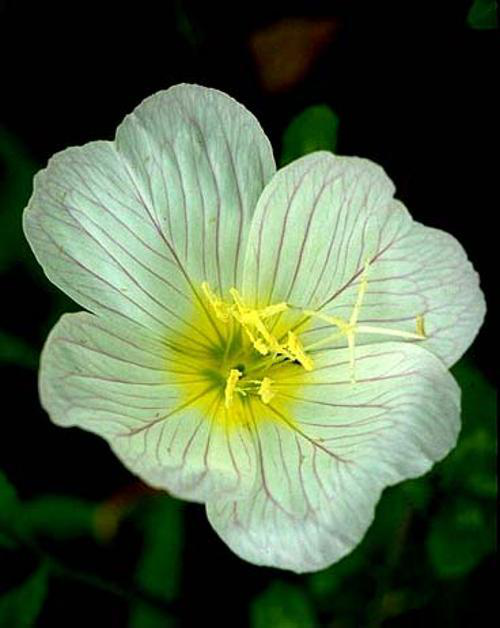

In [29]:
image_pil

In [30]:
image_np = process_image(image_pil)

In [31]:
image_np.dtype

dtype('float32')

In [32]:
image_np[0][137][130:135]

array([ 0.6220567 ,  0.33093593, -0.09718303, -0.2855553 , -1.3644148 ],
      dtype=float32)

Expected output.
```
>>> image_np_norm_t[0][0][:5]
array([ 0.62205668,  0.33093587, -0.09718298, -0.28555527, -1.36441476])
```

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [33]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

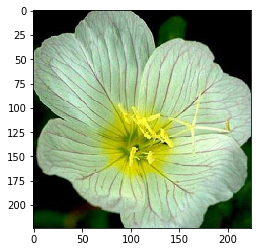

In [34]:
imshow(torch.tensor(image_np))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [35]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    image_pil = Image.open(image_path)
    image_np = process_image(image_pil)
    image_tensor = torch.tensor(np.array([image_np]))
    if train_on_gpu:
        image_tensor = image_tensor.cuda()
    output = d121(image_tensor)
    return output.topk(topk)

In [36]:
image_path = "../flower_data/valid/1/image_06739.jpg"
output_top5 = predict(image_path, model=d121, topk=5)
print("expected", class_to_idx['1'])
print(output_top5)

expected 0
(tensor([[14.5464,  7.3064,  5.9708,  5.7139,  5.6038]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[ 0,  6, 87, 84, 13]], device='cuda:0'))


In [37]:
file_names = ["image_05094.jpg", "image_05101.jpg", "image_05124.jpg", \
              "image_05136.jpg", "image_05137.jpg", "image_05142.jpg"]
for file_name in file_names:
    image_path = "../flower_data/valid/2/%s" % file_name
    output_top5 = predict(image_path, model=d121, topk=5)
    print("expected", class_to_idx['2'])
    print(output_top5)

expected 14
(tensor([[14.5269,  5.6820,  5.1439,  4.9187,  4.4522]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[14, 81, 73, 10, 66]], device='cuda:0'))
expected 14
(tensor([[14.6819,  5.9752,  5.2284,  5.0012,  4.9828]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[14, 50, 32, 12, 93]], device='cuda:0'))
expected 14
(tensor([[16.8840,  6.5371,  6.0140,  4.4327,  4.4074]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[14, 12, 50, 77,  7]], device='cuda:0'))
expected 14
(tensor([[16.1697,  5.4495,  4.5139,  4.2921,  3.9437]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[14, 50, 69, 61, 55]], device='cuda:0'))
expected 14
(tensor([[12.2433,  4.9226,  4.6340,  4.5642,  4.5598]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[14, 12, 98, 77, 50]], device='cuda:0'))
expected 14
(tensor([[17.3063,  6.0801,  5.0504,  4.8637,  4.5221]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[14, 93,  4, 99, 50]], device='cuda:0')

In [38]:
file_names = ["image_05164.jpg", "image_05168.jpg", "image_05188.jpg", \
              "image_05192.jpg", "image_05196.jpg", "image_05199.jpg", \
              "image_05209.jpg"]
for file_name in file_names:
    image_path = "../flower_data/valid/5/%s" % file_name
    output_top5 = predict(image_path, model=d121, topk=5)
    print("expected", class_to_idx['5'])
    print(output_top5)

expected 47
(tensor([[8.6783, 5.9959, 5.6195, 5.0219, 5.0102]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[47, 80, 64,  2, 62]], device='cuda:0'))
expected 47
(tensor([[12.6323,  6.9821,  6.0847,  5.9388,  5.3301]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[47, 38, 52, 48, 44]], device='cuda:0'))
expected 47
(tensor([[14.3894,  9.4411,  8.6380,  8.5563,  8.0022]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[47, 52, 38,  2, 51]], device='cuda:0'))
expected 47
(tensor([[11.5280,  5.7909,  5.4518,  5.2837,  5.1547]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[47, 38, 62, 46, 51]], device='cuda:0'))
expected 47
(tensor([[11.3210,  9.8253,  5.9286,  5.9016,  4.2231]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[38, 47, 21, 54, 30]], device='cuda:0'))
expected 47
(tensor([[9.3768, 6.9396, 6.2669, 5.8103, 5.3170]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[47, 21, 54, 38, 30]], device='cuda:0'))
expected

In [39]:
file_names = ["image_08002.jpg", "image_08002.jpg", "image_08014.jpg", \
              "image_08038.jpg", "image_08040.jpg", "image_08041.jpg"]
for file_name in file_names:
    image_path = "../flower_data/valid/102/%s" % file_name
    output_top5 = predict(image_path, model=d121, topk=5)
    print("expected", class_to_idx['102'])
    print(output_top5)

expected 4
(tensor([[14.9726,  8.3948,  6.5562,  6.2934,  5.4384]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[ 4, 12, 55, 34, 78]], device='cuda:0'))
expected 4
(tensor([[14.9726,  8.3948,  6.5562,  6.2934,  5.4384]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[ 4, 12, 55, 34, 78]], device='cuda:0'))
expected 4
(tensor([[17.1374,  7.5818,  7.5617,  6.8186,  5.7555]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[ 4, 81, 73, 12, 78]], device='cuda:0'))
expected 4
(tensor([[16.4295, 10.0159,  7.6706,  6.6538,  5.8993]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[ 4, 12, 79, 58, 78]], device='cuda:0'))
expected 4
(tensor([[17.6348, 10.6832,  8.4568,  6.8175,  6.5646]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[ 4, 81, 12, 18, 71]], device='cuda:0'))
expected 4
(tensor([[16.0650,  7.8652,  6.9177,  6.3528,  5.5714]],
       device='cuda:0', grad_fn=<TopkBackward>), tensor([[ 4, 81, 79, 73, 18]], device='cuda:0'))


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [40]:
# TODO: Display an image along with the top 5 classes
def predict_w_graph(model, image_dir='1', image_name='image_06739.jpg'):
    image_path = "../flower_data/valid/%s/%s" % (image_dir, image_name)

    print(cat_to_name[image_dir])

    image_pil = Image.open(image_path)
    image_np = process_image(image_pil)
    imshow(torch.tensor(image_np))
    plt.show()
    
    output_top5 = predict(image_path, model, topk=5)
    prediction_accuracy = output_top5[0][0].detach().cpu().numpy()
    prediction_idx = output_top5[1][0].detach().cpu().numpy()
    prediction_class_name = []
    for i in prediction_idx:
        prediction_class = idx_to_class[i]
        prediction_class_name.append(cat_to_name[prediction_class])
        
    fig, ax = plt.subplots()
    y_pos = np.arange(len(prediction_class_name))
    ax.barh(y_pos, prediction_accuracy, color='orange')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(np.array(prediction_class_name))
    ax.invert_yaxis()
    plt.show()

pink primrose


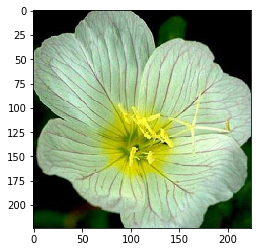

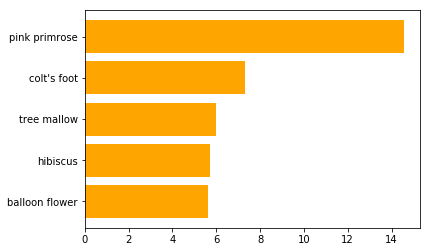

In [41]:
predict_w_graph(d121, image_dir='1', image_name='image_06739.jpg')

toad lily


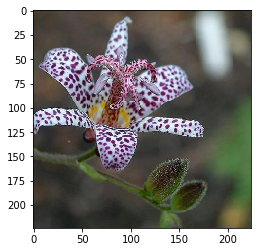

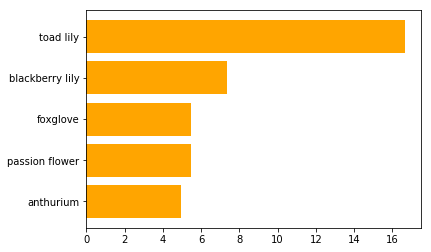

In [42]:
predict_w_graph(d121, image_dir='79', image_name='image_06695.jpg')

blackberry lily


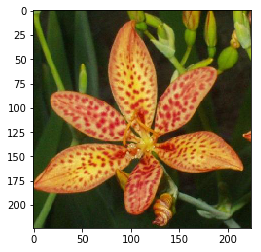

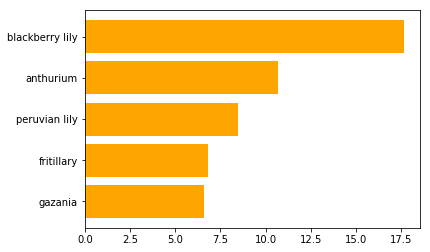

In [43]:
predict_w_graph(d121, image_dir='102', image_name='image_08040.jpg')

```python
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


def load_checkpoint(filepath='/home/workspace/checkpoint.pyt'):

    checkpoint = torch.load(filepath, map_location='cpu')
    
    model_output_class = checkpoint['model_output_class']
    model = models.vgg16(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    n_inputs = model.classifier[6].in_features
    last_layer = nn.Linear(n_inputs, model_output_class)
    model.classifier[6] = last_layer
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model


# Load your model to this variable
model = load_checkpoint(filepath='/home/workspace/checkpoint.pyt')
   
# If you used something other than 224x224 cropped images, set the correct size here
image_size = 224
# Values you used for normalizing the images. Default here are for 
# pretrained models from torchvision.
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
```

## Dispay Error

In [44]:
# TODO: Display an image along with the top 5 classes
def display_error(model, image_tensor, expected_idx, output, topk):
    imshow(image_tensor.cpu())
    plt.show()
    
    expected_class = idx_to_class[int(expected_idx.cpu().numpy())]
    print("expected:", expected_class, '-', cat_to_name[expected_class])
    
    output_top5 = output.topk(topk)
    prediction_accuracy = output_top5[0].detach().cpu().numpy()
    prediction_idx = output_top5[1].detach().cpu().numpy()
    prediction_class_name = []
    for i in prediction_idx:
        prediction_class = idx_to_class[i]
        prediction_class_name.append(cat_to_name[prediction_class])
        
    print("top-1 result:", idx_to_class[int(prediction_idx[0])], '-', \
          prediction_class_name[0])
        
    fig, ax = plt.subplots()
    y_pos = np.arange(len(prediction_class_name))
    ax.barh(y_pos, prediction_accuracy, color='orange')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(np.array(prediction_class_name))
    ax.invert_yaxis()
    plt.show()

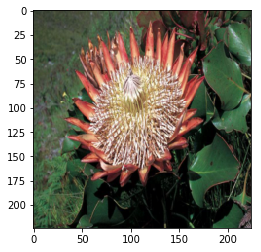

expected: 13 - king protea
top-1 result: 29 - artichoke


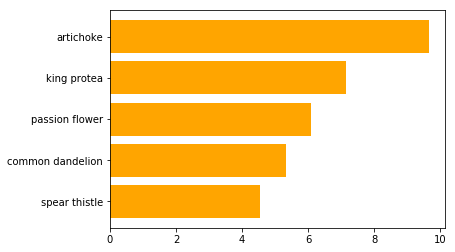

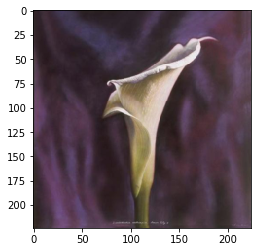

expected: 20 - giant white arum lily
top-1 result: 88 - cyclamen


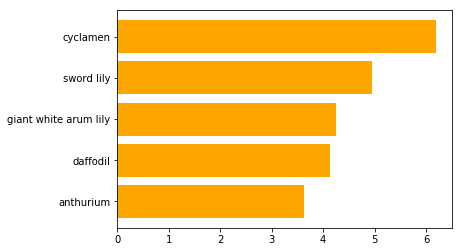

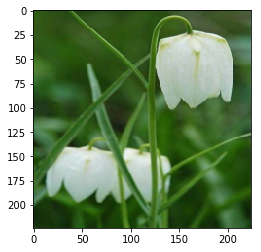

expected: 23 - fritillary
top-1 result: 20 - giant white arum lily


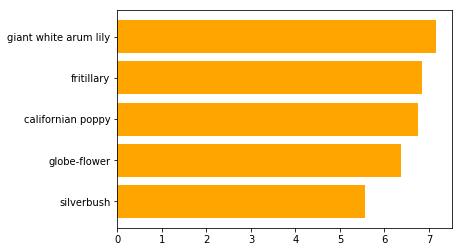

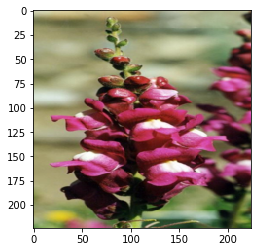

expected: 11 - snapdragon
top-1 result: 94 - foxglove


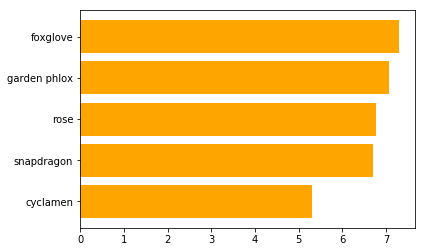

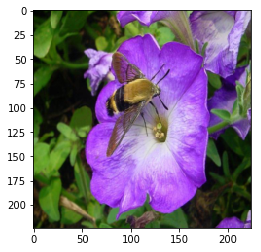

expected: 51 - petunia
top-1 result: 33 - love in the mist


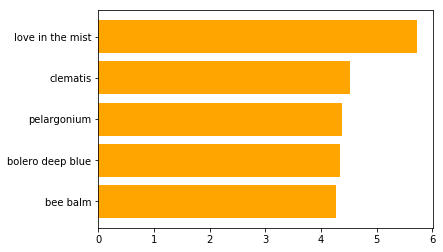

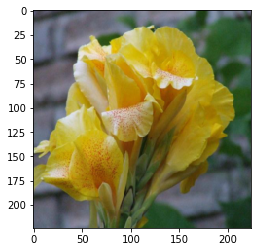

expected: 90 - canna lily
top-1 result: 74 - rose


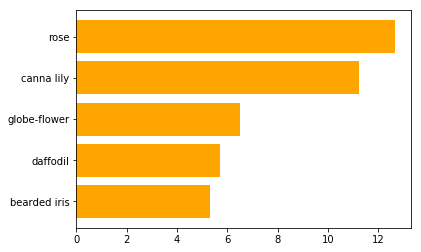

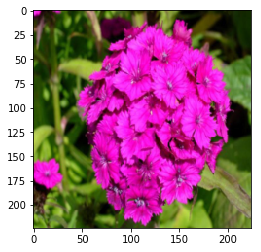

expected: 30 - sweet william
top-1 result: 22 - pincushion flower


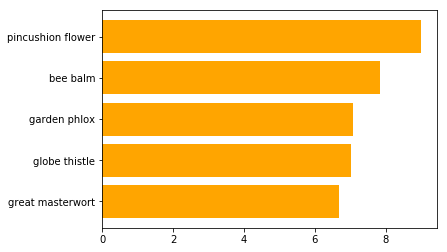

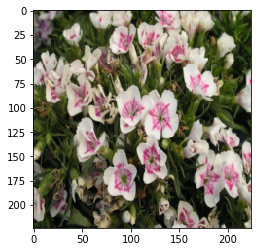

expected: 30 - sweet william
top-1 result: 32 - garden phlox


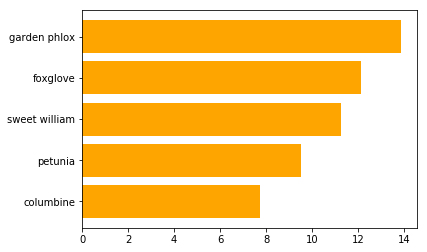

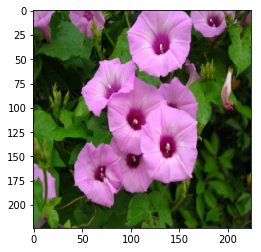

expected: 76 - morning glory
top-1 result: 32 - garden phlox


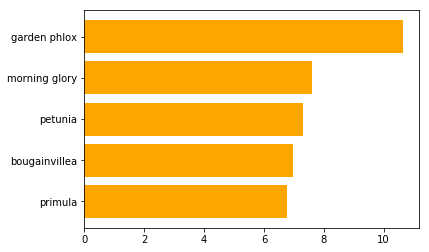

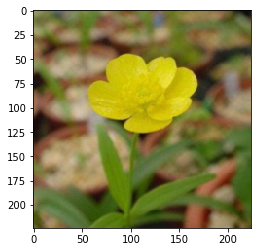

expected: 48 - buttercup
top-1 result: 46 - wallflower


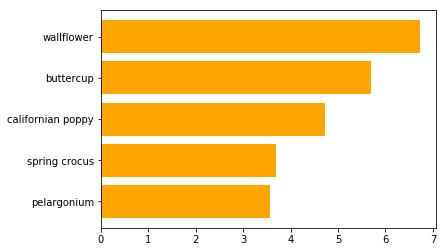

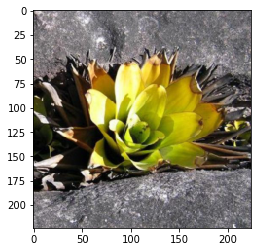

expected: 99 - bromelia
top-1 result: 29 - artichoke


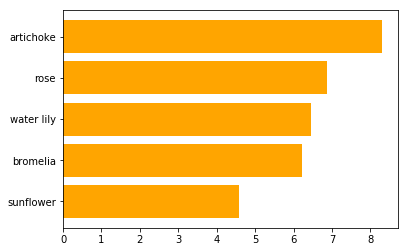

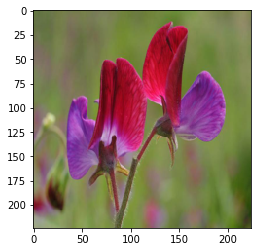

expected: 4 - sweet pea
top-1 result: 57 - gaura


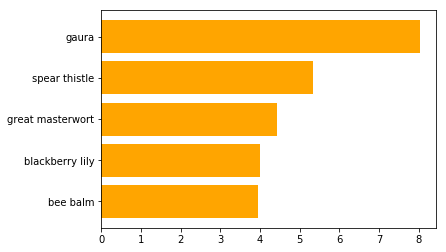

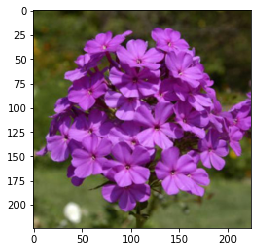

expected: 32 - garden phlox
top-1 result: 22 - pincushion flower


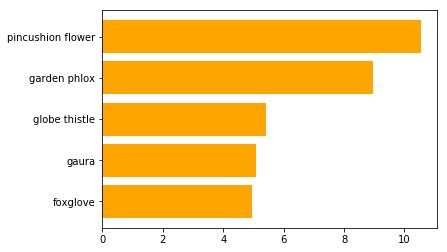

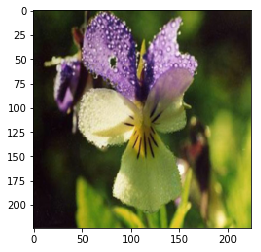

expected: 52 - wild pansy
top-1 result: 94 - foxglove


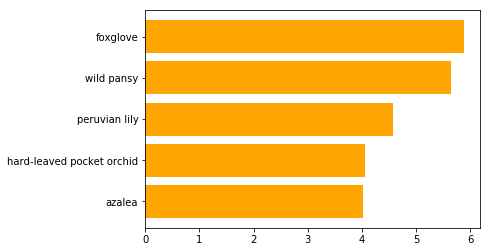

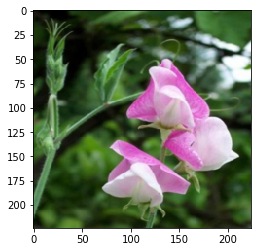

expected: 4 - sweet pea
top-1 result: 3 - canterbury bells


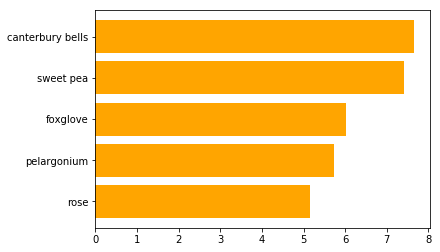

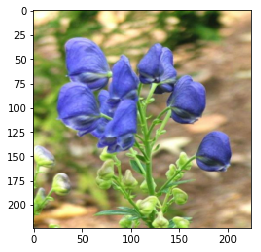

expected: 9 - monkshood
top-1 result: 25 - grape hyacinth


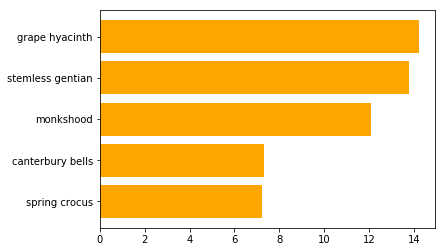

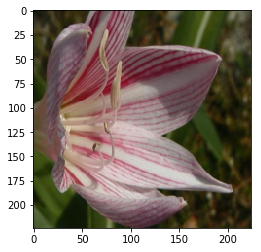

expected: 91 - hippeastrum
top-1 result: 57 - gaura


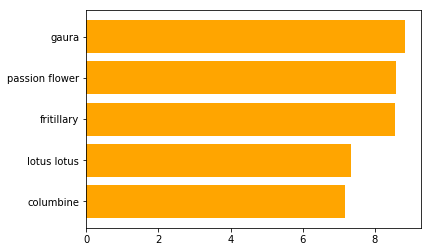

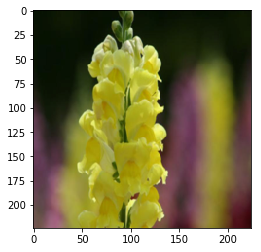

expected: 11 - snapdragon
top-1 result: 47 - marigold


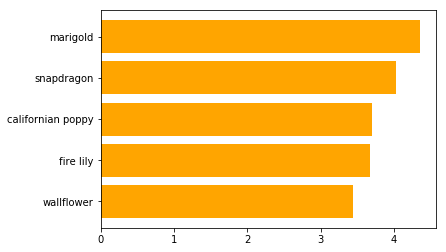

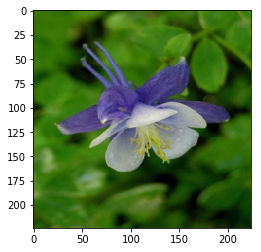

expected: 84 - columbine
top-1 result: 77 - passion flower


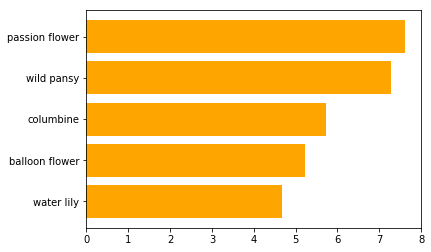

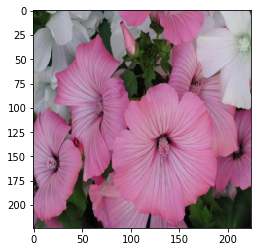

expected: 86 - tree mallow
top-1 result: 51 - petunia


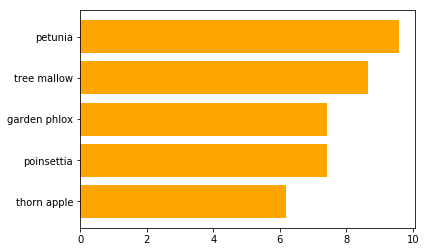

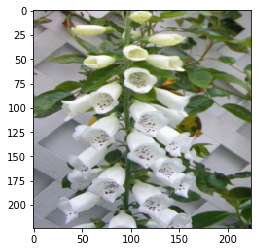

expected: 93 - ball moss
top-1 result: 94 - foxglove


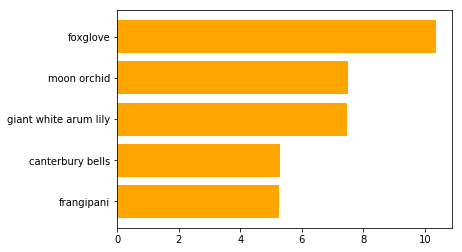

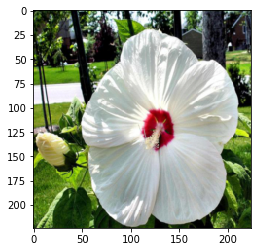

expected: 83 - hibiscus
top-1 result: 76 - morning glory


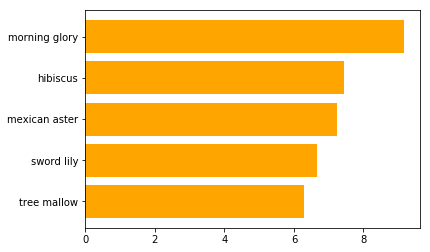

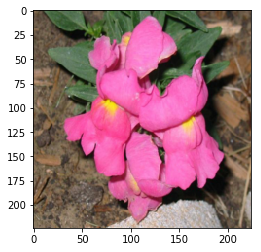

expected: 11 - snapdragon
top-1 result: 45 - bolero deep blue


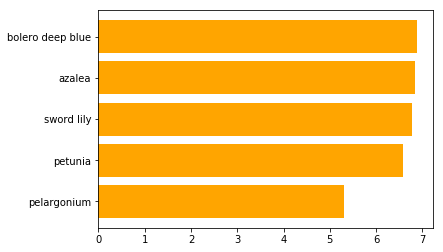

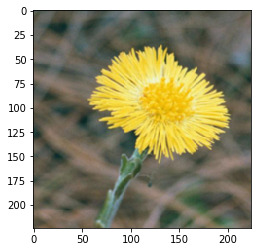

expected: 12 - colt's foot
top-1 result: 50 - common dandelion


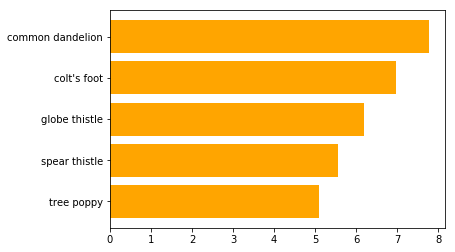

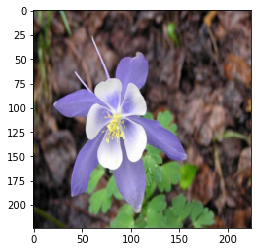

expected: 84 - columbine
top-1 result: 28 - stemless gentian


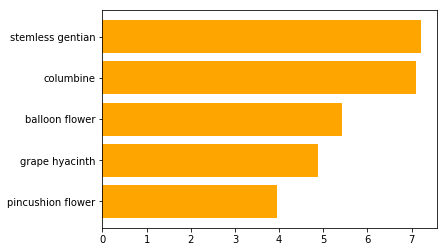

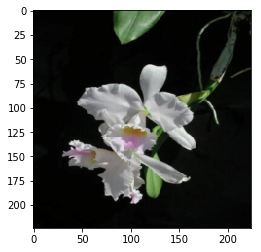

expected: 36 - ruby-lipped cattleya
top-1 result: 57 - gaura


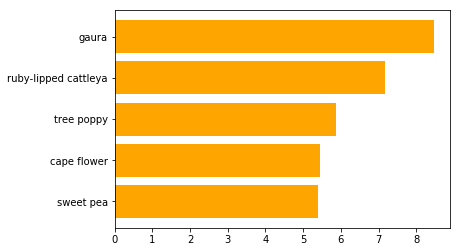

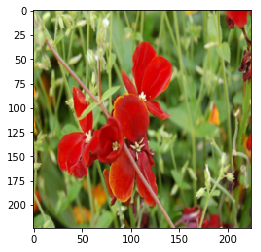

expected: 46 - wallflower
top-1 result: 56 - bishop of llandaff


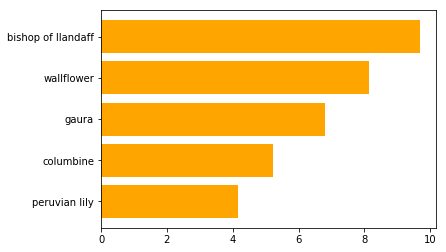

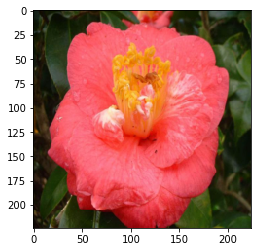

expected: 96 - camellia
top-1 result: 74 - rose


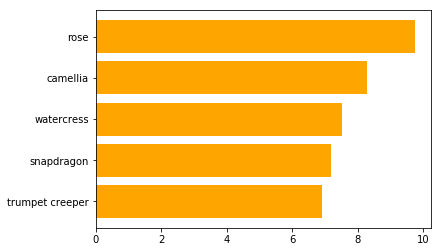

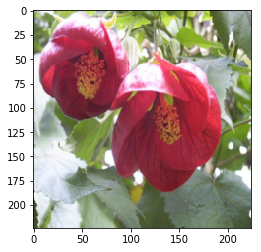

expected: 97 - mallow
top-1 result: 96 - camellia


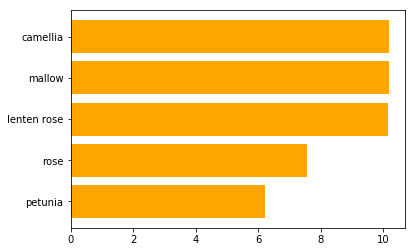

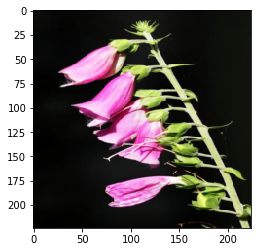

expected: 94 - foxglove
top-1 result: 37 - cape flower


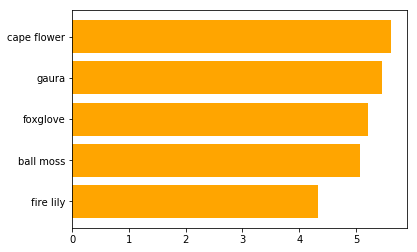

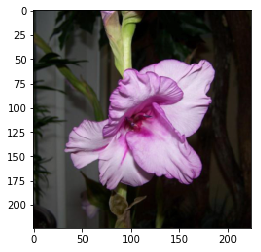

expected: 43 - sword lily
top-1 result: 18 - peruvian lily


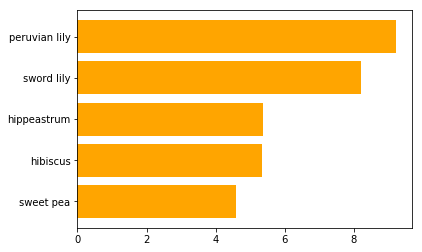

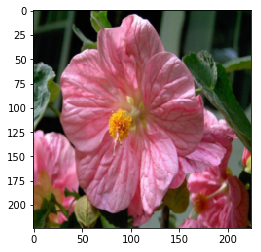

expected: 96 - camellia
top-1 result: 97 - mallow


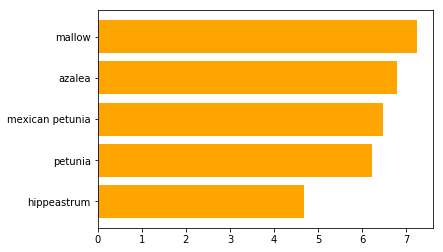

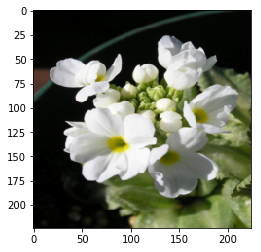

expected: 53 - primula
top-1 result: 7 - moon orchid


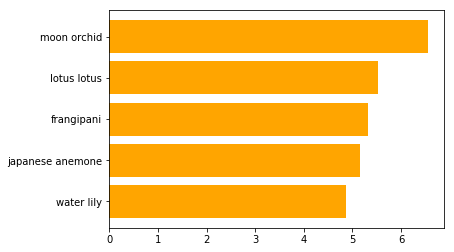

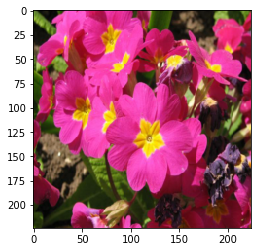

expected: 53 - primula
top-1 result: 95 - bougainvillea


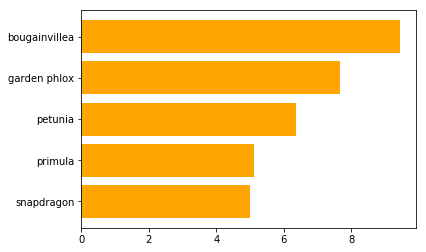

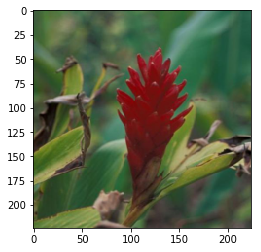

expected: 24 - red ginger
top-1 result: 92 - bee balm


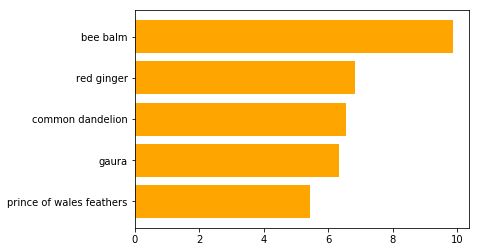

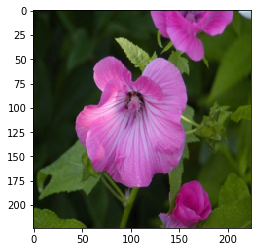

expected: 86 - tree mallow
top-1 result: 51 - petunia


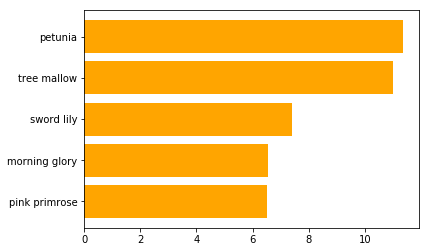

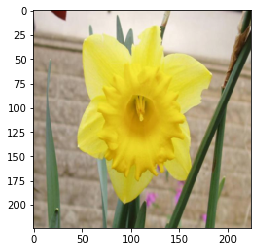

expected: 42 - daffodil
top-1 result: 43 - sword lily


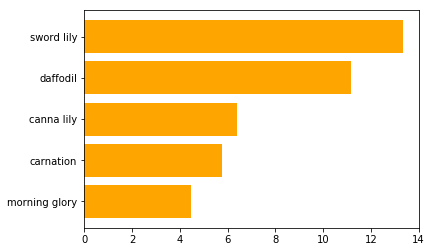

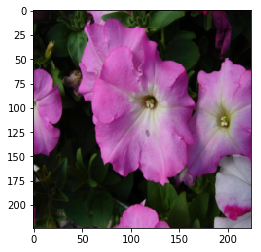

expected: 51 - petunia
top-1 result: 32 - garden phlox


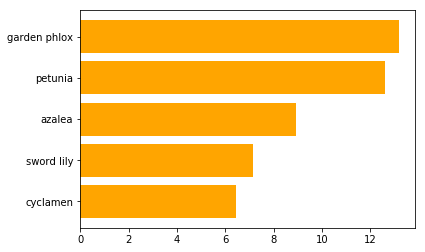

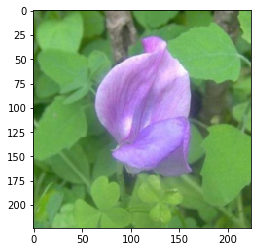

expected: 4 - sweet pea
top-1 result: 55 - pelargonium


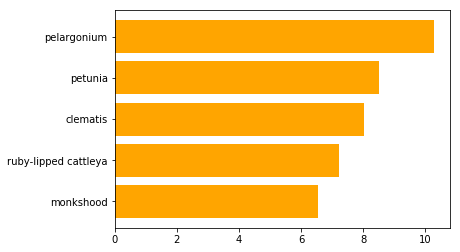

Test Loss: 0.222647

Test Accuracy of pink primrose: 100% ( 8/ 8)
Test Accuracy of hard-leaved pocket orchid: 100% ( 4/ 4)
Test Accuracy of canterbury bells: 100% ( 6/ 6)
Test Accuracy of sweet pea: 100% ( 5/ 5)
Test Accuracy of english marigold: 100% ( 6/ 6)
Test Accuracy of tiger lily: 70% ( 7/10)
Test Accuracy of moon orchid: 80% ( 4/ 5)
Test Accuracy of bird of paradise: 80% ( 4/ 5)
Test Accuracy of monkshood: 100% ( 1/ 1)
Test Accuracy of globe thistle: 100% ( 7/ 7)
Test Accuracy of snapdragon: 100% ( 2/ 2)
Test Accuracy of colt's foot: 100% (16/16)
Test Accuracy of king protea: 100% (11/11)
Test Accuracy of spear thistle: 100% ( 4/ 4)
Test Accuracy of yellow iris: 100% ( 6/ 6)
Test Accuracy of globe-flower: 85% ( 6/ 7)
Test Accuracy of purple coneflower: 100% ( 4/ 4)
Test Accuracy of peruvian lily: 100% ( 8/ 8)
Test Accuracy of balloon flower: 91% (11/12)
Test Accuracy of giant white arum lily: 80% ( 4/ 5)
Test Accuracy of fire lily: 100% ( 2/ 2)
Test Accuracy of pincushion flowe

In [45]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(len(cat_to_name)))
class_total = list(0. for i in range(len(cat_to_name)))

# iterate over test data
d121.eval() # eval mode
for data, target in valid_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = d121(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        # display error
        if correct_tensor[i] == 0:
            display_error(d121, data[i], target[i], output[i], topk=5)

# calculate avg test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(cat_to_name)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            cat_to_name[str(i+1)], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))